# Import and classes bpm

In [22]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

import gzip
from typing import Union
import json

import awkward as ak
import pandas as pd

In [2]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):

    @property 
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        #return self["orbit", "name"]
        return ak.Array([bpm for i, bpm in enumerate(self['name']) if self['plane'][i] == 'H'])
    
    @property
    def bpms_ver(self):
        return ak.Array([bpm for i, bpm in enumerate(self['name']) if self['plane'][i] == 'V'])
    
    def orbit_plane(self, plane: str = "H"):
        if plane == 'H':
            return ak.Array([self['position'][self.index[bpm]] for bpm in self.bpms_hor])
        elif plane == 'V':
            return ak.Array([self['position'][self.index[bpm]] for bpm in self.bpms_ver])
        else:
            ValueError('No valid plane was given !')

    def orbit_position(self, name: str):
        # Return position for a given BPM name
        return self['position'][self.index[name]]
    
    def restr_orbit_plane(self, bpm_list_restr):
        return ak.Array([self['position'][self.index[bpm]] for bpm in bpm_list_restr])

    
    def _build_index(self):
        self._index = {}
        for i, bpm in enumerate(self['name']):
            self._index[bpm] = i
    
    
ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior


In [3]:
class CorrectorsCollectionBehavior(ak.Array):
    @property 
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def corr_hor(self):
        #return self["orbit", "name"]
        return ak.Array([corr for i, corr in enumerate(self['name']) if self['plane'][i] == 'H'])
    
    @property
    def corr_ver(self):
        return ak.Array([corr for i, corr in enumerate(self['name']) if self['plane'][i] == 'V'])
    
    def kick_plane(self, plane: str = "H"):
        if plane == 'H':
            return ak.Array([self['kick'][self.index[corr]] for corr in self.corr_hor])
        elif plane == 'V':
            return ak.Array([self['kick'][self.index[corr]] for corr in self.corr_ver])
        else:
            ValueError('No valid plane was given !')

    def kick_position(self, name: str):
        # Return position for a given BPM name
        return self['kick'][self.index[name]]

    def _build_index(self):
        self._index = {}
        for i, corr in enumerate(self['name']):
            self._index[corr] = i

ak.behavior["*", "CorrectorsCollection"] = CorrectorsCollectionBehavior

In [4]:
def load_bpm_file_data(path: Union[str, Path]) -> ak.Array:
    """
    Load a .data or .data.gz file into an Awkward Array with BPMCollection behavior.
    """

    #file opening with different compression
    path = Path(path)
    opener = gzip.open if path.suffix == ".gz" else open
    with opener(path, "rt") as f:
        lines = f.readlines()

    #Sections of file
    header_lines = []
    orbit_lines = []
    corrector_lines = []

    mode = "header"
    for line in lines:
        if line.startswith("# MONITOR"):
            mode = "orbit"
            continue
        elif line.startswith("# CORRECTOR"):
            mode = "corrector"
            continue

        if mode == "header":
            header_lines.append(line)
        elif mode == "orbit":
            if not line.startswith('*'):
                orbit_lines.append(line)
        elif mode == "corrector":
            if not line.startswith('*'):
                corrector_lines.append(line)

    #Metadata
    meta = {}  # <-- parse @ DATE, @ DPP, etc.
    for line in header_lines:
        if not line.startswith('@'):
            continue
        parts = line.strip().split(maxsplit=3)
        if len(parts) < 4:
            continue
        _, key, dtype, value = parts
        if dtype == "%d":
            value = int(value)
        elif dtype == "%f":
            value = float(value)
        elif dtype == "%s":
            value = value.strip('"')
        meta[key] = ak.Array([value])
    
    
    #Orbit
    orbit = {
        "name": [], "plane": [], "beam": [], "position": [],
        "rms": [], "sum": [], 'hw-status': [], 'status' : [], "status_tag": [],
    }
    # Fill orbit[...] from orbit_lines
    for line in orbit_lines:
        parts = line.strip().split(maxsplit=9)
        assert len(parts)==9
        for i, key in enumerate(list(orbit.keys())):
            value = parts[i]
            # Simple type inference
            try:
                if "." in value:
                    orbit[key].append(float(value))
                else:
                    orbit[key].append(int(value))
            except ValueError:
                if key == 'name':
                    orbit[key].append(value.lower())
                else:
                    orbit[key].append(value)
    
    for key in orbit:
        orbit[key]=ak.Array(orbit[key])
    
    #Correctors
    correctors = {
        "name": [], "plane": [], "beam": [], 'strength_name' : [], "kick": [], "rt_kick": [],
    }
    # Fill correctors[...] from corrector_lines
    for line in corrector_lines:
        parts = line.strip().split(maxsplit=6)
        assert len(parts)==6
        for i, key in enumerate(list(correctors.keys())):
            value = parts[i]
            # Simple type inference
            try:
                if "." in value:
                    correctors[key].append(float(value))
                else:
                    correctors[key].append(int(value))
            except ValueError:
                if key=='name':
                    correctors[key].append(value.lower())
                else:
                    correctors[key].append(value)
    
    for key in correctors:
        correctors[key]=ak.Array(correctors[key])

    #Total dictionary data, idk how to make awkward array out of it
    data = {
        "orbit": ak.Array(orbit, with_name='BPMCollection'),
        "correctors": ak.Array(correctors, with_name='CorrectorsCollection'),
        "meta": ak.Array(meta),
    }

    return data


In [48]:
def load_all_bpm_files(directory_coll):
    bpm_files_by_timestamp = {}

    pattern = re.compile(r"ORBIT_SPSRING_(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})_.*\.data\.gz")

    for file in Path(directory_coll).glob("ORBIT_SPSRING_*.data.gz"):
        match = pattern.match(file.name)
        if match:
            timestamp_raw = match.group(1)
            timestamp = timestamp_raw.replace('_', ' ', 1) # Convert to 'YYYY-MM-DD HH-MM-SS'
            date, time = timestamp.split(" ")
            fixed_time = time.replace("-", ":")
            timestamp = f"{date} {fixed_time}"
            try:
                bpm_files_by_timestamp[timestamp] = load_bpm_file_data(file)
            except (AssertionError, EOFError, OSError, ValueError) as e:
                print(f"Skipping file due to error ({type(e).__name__}): {file}")
                continue

    return bpm_files_by_timestamp

In [ ]:
# Working with timezones
def to_timestamp_CET(tstamp):
    if tstamp is None:
        return None
    else:
        if isinstance(tstamp,int):
            # UNIX timestamps are always UTC
            ts = to_timestamp_UTC(tstamp)
        else:
            ts = pd.Timestamp(tstamp)
        if ts.tz is None:
            return ts.tz_localize('CET')
        else:
            return ts.astimezone('CET')


def to_timestamp_UTC(tstamp):
    if tstamp is None:
        return None
    else:
        ts = pd.Timestamp(tstamp)
        if ts.tz is None:
            return ts.tz_localize('UTC')
        else:
            return ts.astimezone('UTC')


In [ ]:
_DATA_PATH = Path('/Users/lisepauwels/sps_simulations/MD_analysis/20250430/')

def get_tidp_bump(t):
    if not hasattr(t, '__iter__') or isinstance(t, str):
        t = [t]
    t = [to_timestamp_CET(tt) for tt in t]
    if len(np.unique([tt.strftime('%Y%m%d') for tt in t])) > 1:
        raise NotImplementedError
    #path = _DATA_PATH / t[0].strftime('%Y%m%d') / "tidp.json"
    path = _DATA_PATH / "tidp.json"
    if not path.exists():
        return []
    else:
        with path.open('r') as fid:
            data = {to_timestamp_CET(tt): vv for tt, vv in json.load(fid).items()}
        res = []
        for tt in t:
            ts = np.array(list(data.keys()))
            ts = sorted(ts[ts <= to_timestamp_CET(tt)])
            if len(ts) == 0:
                res.append(0.)  # Time is before first logged bump, hence 0mm
            else:
                ts = ts[-1] # Last timestamp with TIDP bump info before tt
                res.append(data[ts])
        return res

In [47]:
def fix_timestamp(ts):
    date, time = ts.split(" ")
    fixed_time = time.replace("-", ":")
    return f"{date} {fixed_time}"

# Loading data with timestamp

In [6]:
directory_coll = Path('/eos/project-c/collimation-team/acquisition_data/SPS/20250430')
directory_coll = Path('/Users/lisepauwels/sps_simulations/MD_analysis/20250430/')

In [ ]:
data_test = load_bpm_file_data(Path(directory_coll, 'ORBIT_SPSRING_2025-04-30_11-00-12_MD5_CY12_TR0.data.gz'))

line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta.json')
tt=line.get_table()
tw = line.twiss()
#tidp drift replacement
env = line.env
s_start_tidp = line.get_s_position('tidp.11434..0')
line.remove(tt.rows['tidp.*'].name)
line.insert(env.place('tidp.11434', at=s_start_tidp), s_tol=1e-6)

tt=line.get_table()
tw = line.twiss()

bpms_hor_in_line = []
s_arr = []
for bpm in data_test['orbit'].bpms_hor:
    if len(tt.rows[f'.*{bpm}.*'].name)>0:
        bpms_hor_in_line.append(bpm)
        if bpm in tt.rows[f'.*{bpm}.*'].name:
            s_arr.append(line.get_s_position(bpm))
        else:
            s_arr.append(line.get_s_position(f'{bpm}..0') + line[f'{bpm}..0']._parent.length/2)

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/75278 [00:00<?, ?it/s]

In [124]:
bpm_dict = load_all_bpm_files(directory_coll)
hor_pos = {to_timestamp_CET(time) : bpm_dict[time]['orbit'].restr_orbit_plane(bpms_hor_in_line) for time in bpm_dict}

Skipping file due to error (AssertionError): /Users/lisepauwels/sps_simulations/MD_analysis/20250430/ORBIT_SPSRING_2025-04-30_12-20-14_MD5_CY186_TR0.data.gz
Skipping file due to error (AssertionError): /Users/lisepauwels/sps_simulations/MD_analysis/20250430/ORBIT_SPSRING_2025-04-30_12-19-47_MD5_CY185_TR0.data.gz
Skipping file due to error (AssertionError): /Users/lisepauwels/sps_simulations/MD_analysis/20250430/ORBIT_SPSRING_2025-04-30_11-25-30_MD5_CY67_TR0.data.gz
Skipping file due to error (AssertionError): /Users/lisepauwels/sps_simulations/MD_analysis/20250430/ORBIT_SPSRING_2025-04-30_11-26-25_MD5_CY69_TR0.data.gz


In [125]:
md_information = {'coast1' : {'timestamps' : [to_timestamp_CET('2025-04-30 10:37:41'),to_timestamp_CET('2025-04-30 10:46:25')], 'energy': 26},
                     'coast2' : {'timestamps' : [to_timestamp_CET('2025-04-30 10:51:01'),to_timestamp_CET('2025-04-30 11:02:03')], 'energy': 26},
                     'coast3' : {'timestamps' : [to_timestamp_CET('2025-04-30 11:04:49'),to_timestamp_CET('2025-04-30 11:16:46')], 'energy': 26},
                     'coast4' : {'timestamps' : [to_timestamp_CET('2025-04-30 11:19:32'),to_timestamp_CET('2025-04-30 11:35:10')], 'energy': 26},
                     'coast5' : {'timestamps' : [to_timestamp_CET('2025-04-30 11:37:56'),to_timestamp_CET('2025-04-30 11:42:04')], 'energy': 26},
                     'coast6' : {'timestamps' : [to_timestamp_CET('2025-04-30 11:44:23'),to_timestamp_CET('2025-04-30 11:46:40')], 'energy': 26},
                     'coast7' : {'timestamps' : [to_timestamp_CET('2025-04-30 11:50:21'),to_timestamp_CET('2025-04-30 11:54:57')], 'energy': 26},
                     'coast8' : {'timestamps' : [to_timestamp_CET('2025-04-30 12:00:56'),to_timestamp_CET('2025-04-30 12:04:37')], 'energy': 26},
                     'coast9' : {'timestamps' : [to_timestamp_CET('2025-04-30 12:08:18'),to_timestamp_CET('2025-04-30 12:12:26')], 'energy': 26},
                     'coast10' : {'timestamps' : [to_timestamp_CET('2025-04-30 12:15:39'),to_timestamp_CET('2025-04-30 12:28:04')], 'energy': 30},
                     'coast11' : {'timestamps' : [to_timestamp_CET('2025-04-30 12:30:50'),to_timestamp_CET('2025-04-30 12:43:15')], 'energy': 30},
                     'coast12' : {'timestamps' : [to_timestamp_CET('2025-04-30 12:45:33'),to_timestamp_CET('2025-04-30 12:51:04')], 'energy': 26},
                     'coast13' : {'timestamps' : [to_timestamp_CET('2025-04-30 12:53:23'),to_timestamp_CET('2025-04-30 13:00:18')], 'energy': 26},
                     'coast14' : {'timestamps' : [to_timestamp_CET('2025-04-30 13:03:02'),to_timestamp_CET('2025-04-30 13:08:06')], 'energy': 26},
                     'coast15' : {'timestamps' : [to_timestamp_CET('2025-04-30 13:19:36'),to_timestamp_CET('2025-04-30 13:23:16')], 'energy': 26},
                     'coast16' : {'timestamps' : [to_timestamp_CET('2025-04-30 13:26:02'),to_timestamp_CET('2025-04-30 13:29:15')], 'energy': 26},
                     'betatron_cycles1' : {'timestamps' : [to_timestamp_CET('2025-04-30 14:59:56'),to_timestamp_CET('2025-04-30 15:06:58')], 'energy': 26},
                     'off_momentum_cycles1' : {'timestamps' : [to_timestamp_CET('2025-04-30 15:07:58'),to_timestamp_CET('2025-04-30 15:15:00')], 'energy' : 26},
                     'coast17' : {'timestamps' : [to_timestamp_CET('2025-04-30 16:30:39'),to_timestamp_CET('2025-04-30 16:34:48')], 'energy': 30},
                     'coast18' : {'timestamps' : [to_timestamp_CET('2025-04-30 16:38:29'),to_timestamp_CET('2025-04-30 16:41:42')], 'energy': 30},
                     'coast19' : {'timestamps' : [to_timestamp_CET('2025-04-30 16:47:41'),to_timestamp_CET('2025-04-30 16:52:16')], 'energy': 30},
                     'coast20' : {'timestamps' : [to_timestamp_CET('2025-04-30 16:56:25'),to_timestamp_CET('2025-04-30 17:00:06')], 'energy': 30},
                     'betatron_cycles2' : {'timestamps' : [to_timestamp_CET('2025-04-30 17:14:17'),to_timestamp_CET('2025-04-30 17:54:30')], 'energy': 26},
                     'off_momentum_cycles2' : {'timestamps' : [to_timestamp_CET('2025-04-30 17:54:42'),to_timestamp_CET('2025-04-30 18:10:00')], 'energy': 26},
                     }

def get_timestamps_orbit_within_interval(t_start, t_end, timestamps_orbits):
    return [ts for ts in timestamps_orbits if t_start <= ts <= t_end]

for key in md_information:
    md_information[key]['orbit_ts_files'] = get_timestamps_orbit_within_interval(md_information[key]['timestamps'][0],
                                                   md_information[key]['timestamps'][1],
                                                   sorted(list(hor_pos.keys())))

In [62]:
blm_tidp = 'SP.BLML.11451.ILS_TIDP'
s_blm_tidp = 458.67188304
s_tidp = line.get_s_position('tidp.11434')

# Linear interpolation

In [177]:
for key in md_information:
    md_information[key]['tidp_bump_theoretical'] = np.array(get_tidp_bump(md_information[key]['orbit_ts_files']))
    md_information[key]['tidp_bump_md'] = np.array([bpm_dict[str(ts).split('+')[0]]['orbit'].orbit_position('bph.11408') for ts in md_information[key]['orbit_ts_files']])*1e-6
    md_information[key]['tidp_bump_md2'] = np.array([bpm_dict[str(ts).split('+')[0]]['orbit'].orbit_position('bph.11608') for ts in md_information[key]['orbit_ts_files']])*1e-6

In [91]:
timestamps_md_energy = {26 : {'begin' : [pd.Timestamp('2025-04-30 10:37:41', tz='Europe/Paris'), pd.Timestamp('2025-04-30 12:45:33', tz='Europe/Paris'), 
                                         pd.Timestamp('2025-04-30 14:59:56', tz='Europe/Paris'), pd.Timestamp('2025-04-30 15:07:58', tz='Europe/Paris'),
                                         pd.Timestamp('2025-04-30 17:14:17', tz='Europe/Paris')],
                              'end' : [pd.Timestamp('2025-04-30 12:12:26', tz='Europe/Paris'), pd.Timestamp('2025-04-30 13:29:15', tz='Europe/Paris'), 
                                       pd.Timestamp('2025-04-30 15:06:58', tz='Europe/Paris'), pd.Timestamp('2025-04-30 15:15:00', tz='Europe/Paris'),
                                       pd.Timestamp('2025-04-30 17:54:30', tz='Europe/Paris')]},
                        30 : {'begin' : [pd.Timestamp('2025-04-30 12:15:39', tz='Europe/Paris'), pd.Timestamp('2025-04-30 16:30:39', tz='Europe/Paris')],
                              'end' : [pd.Timestamp('2025-04-30 12:43:15', tz='Europe/Paris'), pd.Timestamp('2025-04-30 17:00:06', tz='Europe/Paris')]}}

In [162]:
# coast = 'coast4'
# plt.close()
# plt.figure()
# plt.plot(md_information[coast]['orbit_ts_files'], md_information[coast]['tidp_bump_theoretical'], '*-', color='blue', label='TIDP bump theoretical')
# plt.plot(md_information[coast]['orbit_ts_files'], md_information[coast]['tidp_bump_md'], '*-', color='red', label='TIDP bump measured')

(np.float64(20208.388564814813), np.float64(20208.399421296297))

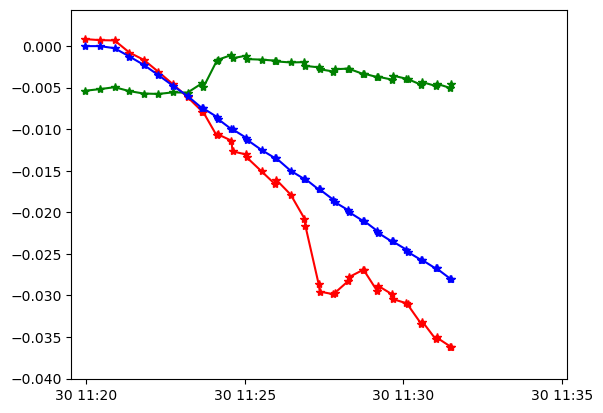

In [178]:
plt.close()
plt.figure()
for key in md_information:
    plt.plot(md_information[key]['orbit_ts_files'], md_information[key]['tidp_bump_md'], '*-', color='red')
    plt.plot(md_information[key]['orbit_ts_files'], md_information[key]['tidp_bump_md2'], '*-', color='green')
    plt.plot(md_information[key]['orbit_ts_files'], md_information[key]['tidp_bump_theoretical'], '*-', color='blue')

plt.xlim(md_information['coast4']['timestamps'][0], md_information['coast4']['timestamps'][1])

In [185]:
def get_straigth(s, x1, x2, s1, s2):
    """
    Get the line equation y = mx + b
    """
    m = (x2 - x1) / (s2 - s1)
    b = x1 - m * s1
    return m * s + b

(np.float64(20208.388564814813), np.float64(20208.399421296297))

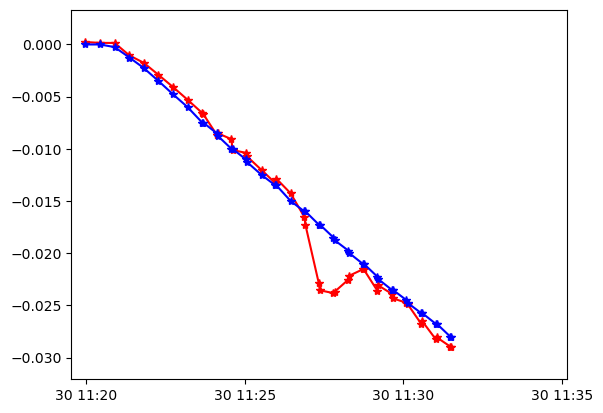

In [ ]:
#Linear fit with fitting factor chosen by hand
plt.close()
plt.figure()
coast = 'coast4'

tidp_pos_interp = line.get_s_position('tidp.11434') + line['tidp.11434'].length/2
bph_11408_pos_interp = line.get_s_position('bph.11408..0') + line['bph.11408..0']._parent.length/2
bph_11608_pos_interp = line.get_s_position('bph.11608..0') + line['bph.11608..0']._parent.length/2

fitting_factor = 0.87
for key in md_information:
    #plt.plot(md_information[key]['orbit_ts_files'], md_information[key]['tidp_bump_md'], '*-')
    plt.plot(md_information[key]['orbit_ts_files'], 
             get_straigth(tidp_pos_interp, md_information[key]['tidp_bump_md'], md_information[key]['tidp_bump_md2'], 
                          bph_11408_pos_interp, bph_11608_pos_interp)*fitting_factor, 
            '*-', color='red')
    plt.plot()
    plt.plot(md_information[key]['orbit_ts_files'], 
             md_information[key]['tidp_bump_theoretical'], '*-', color='blue')

plt.xlim(md_information[coast]['timestamps'][0], md_information[coast]['timestamps'][1])

There is a discrepency that looks dependant on the bump.

I added a fitting factor but adjusted manually

# Bump fitting based on simulation

In [292]:
bump_vals = np.linspace(0, -30e-3, num=int(30/0.25 + 1))

In [294]:
bump_vals

array([ 0.     , -0.00025, -0.0005 , -0.00075, -0.001  , -0.00125,
       -0.0015 , -0.00175, -0.002  , -0.00225, -0.0025 , -0.00275,
       -0.003  , -0.00325, -0.0035 , -0.00375, -0.004  , -0.00425,
       -0.0045 , -0.00475, -0.005  , -0.00525, -0.0055 , -0.00575,
       -0.006  , -0.00625, -0.0065 , -0.00675, -0.007  , -0.00725,
       -0.0075 , -0.00775, -0.008  , -0.00825, -0.0085 , -0.00875,
       -0.009  , -0.00925, -0.0095 , -0.00975, -0.01   , -0.01025,
       -0.0105 , -0.01075, -0.011  , -0.01125, -0.0115 , -0.01175,
       -0.012  , -0.01225, -0.0125 , -0.01275, -0.013  , -0.01325,
       -0.0135 , -0.01375, -0.014  , -0.01425, -0.0145 , -0.01475,
       -0.015  , -0.01525, -0.0155 , -0.01575, -0.016  , -0.01625,
       -0.0165 , -0.01675, -0.017  , -0.01725, -0.0175 , -0.01775,
       -0.018  , -0.01825, -0.0185 , -0.01875, -0.019  , -0.01925,
       -0.0195 , -0.01975, -0.02   , -0.02025, -0.0205 , -0.02075,
       -0.021  , -0.02125, -0.0215 , -0.02175, -0.022  , -0.02

In [268]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta.json')
tt=line.get_table()
tw = line.twiss()
#tidp drift replacement
env = line.env
s_start_tidp = line.get_s_position('tidp.11434..0')
line.remove(tt.rows['tidp.*'].name)
line.insert(env.place('tidp.11434', at=s_start_tidp), s_tol=1e-6)

tt=line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/75278 [00:00<?, ?it/s]

In [269]:
env = line.env

line['bump.11207'] = 0
line['bump.11407'] = 0
line['bump.11607'] = 0
line['bump.12207'] = 0

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']
line.ref['mdh.12207'].knl[0] += line.vars['bump.12207']

In [273]:
xpos_vals = {'bph.11408' : [], 'bph.11608' : [], 'tidp.11434' : []}
for i in range(len(bump_vals)):
    opt = line.match(
        solve=False,
        start='mdh.11007',
        end='mdhw.11732',
        init=tw, 
        vary=[
            xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
        ],
        targets = [
            xt.Target('x', bump_vals[i], at='tidp.11434'),
            xt.TargetSet(['x', 'px'], value=tw, at='mdhw.11732')
        ]
        )
    opt.run_jacobian(10)
    tw_after = line.twiss()
    xpos_vals['bph.11408'].append(tw_after.rows['bph.11408..0'].x[0])
    xpos_vals['bph.11608'].append(tw_after.rows['bph.11608..0'].x[0])
    xpos_vals['tidp.11434'].append(tw_after.rows['tidp.11434'].x[0])


                                             
Optimize - start penalty: 0.0002451                         
Matching: model call n. 6 penalty = 3.3091e-09              
Optimize - end penalty:  3.30909e-09                            
                                             
Optimize - start penalty: 0.0025                            
Matching: model call n. 11 penalty = 2.8527e-14              
Optimize - end penalty:  2.85265e-14                            
                                             
Optimize - start penalty: 0.0025                            
Matching: model call n. 11 penalty = 2.8331e-14              
Optimize - end penalty:  2.83311e-14                            
                                             
Optimize - start penalty: 0.0025                            
Matching: model call n. 11 penalty = 2.8651e-14              
Optimize - end penalty:  2.86511e-14                            
                                             
Optimize - start pe

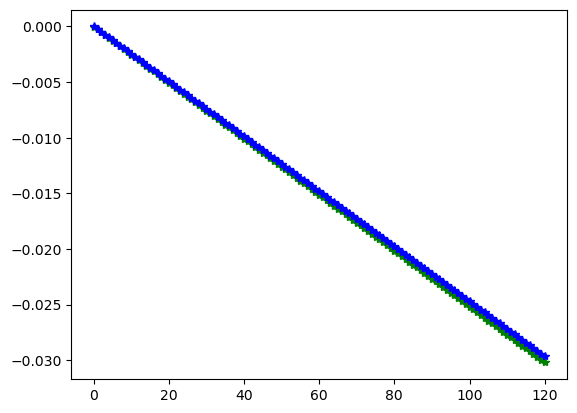

In [ ]:
plt.close()
plt.figure()
coast = 'coast4'

tidp_pos_interp = line.get_s_position('tidp.11434') + line['tidp.11434'].length/2
bph_11408_pos_interp = line.get_s_position('bph.11408..0') + line['bph.11408..0']._parent.length/2
bph_11608_pos_interp = line.get_s_position('bph.11608..0') + line['bph.11608..0']._parent.length/2

fitting_factor = 0.87
#plt.plot(md_information['coast4']['tidp_bump_md'], '*-', color='red')
plt.plot(xpos_vals['bph.11408'], '*-', color='green', label='bph.11408')
plt.plot(xpos_vals['tidp.11434'], '*-', color='blue', label='tidp.11434')



In [ ]:
conversion_factors_list = np.array(xpos_vals['tidp.11434'])/np.array(xpos_vals['bph.11408'])

conversion_factors = {}
for i in range(len(bump_vals)):
    conversion_factors[round(bump_vals[i], 5)] = conversion_factors_list[i]

There is a different slope between tidp and bph.11408, but it looks more in the experimental data

(np.float64(20208.388564814813), np.float64(20208.399421296297))

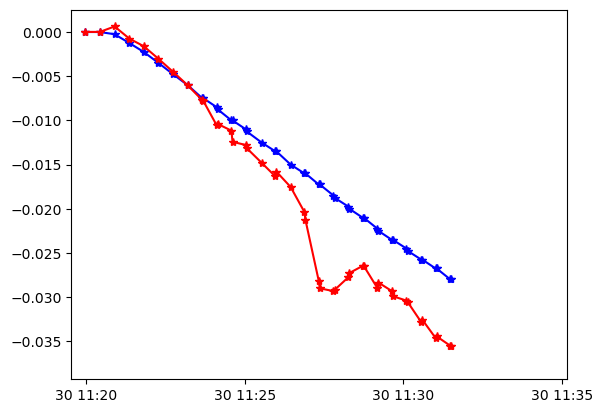

In [ ]:
plt.close()
plt.figure()
coast = 'coast4'

tidp_pos_interp = line.get_s_position('tidp.11434') + line['tidp.11434'].length/2
bph_11408_pos_interp = line.get_s_position('bph.11408..0') + line['bph.11408..0']._parent.length/2
bph_11608_pos_interp = line.get_s_position('bph.11608..0') + line['bph.11608..0']._parent.length/2

for key in md_information:
    plt.plot(md_information[key]['orbit_ts_files'], 
             md_information[key]['tidp_bump_theoretical'], '*-', color='blue')
    bph_vals = []
    for i, bump_val in enumerate(md_information[key]['tidp_bump_theoretical']):
        bph_vals.append(md_information[key]['tidp_bump_md'][i] * conversion_factors[bump_val])
    plt.plot(md_information[key]['orbit_ts_files'], bph_vals, '*-', color='red')

plt.xlim(md_information[coast]['timestamps'][0], md_information[coast]['timestamps'][1])

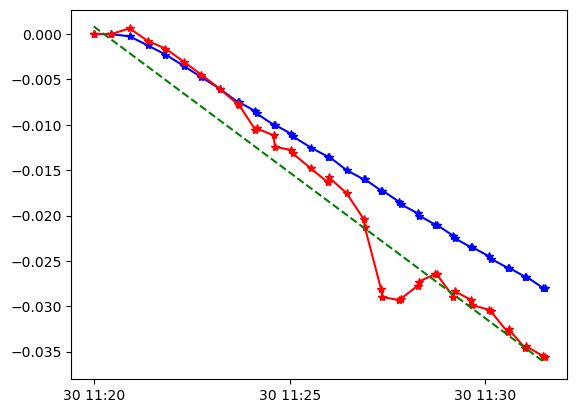

In [345]:
plt.close()
plt.figure()

key='coast4'
plt.plot(md_information[key]['orbit_ts_files'], 
            md_information[key]['tidp_bump_theoretical'], '*-', color='blue')
bph_vals = []
for i, bump_val in enumerate(md_information[key]['tidp_bump_theoretical']):
    bph_vals.append(md_information[key]['tidp_bump_md'][i] * conversion_factors[bump_val])
plt.plot(md_information[key]['orbit_ts_files'], bph_vals, '*-', color='red')
plt.plot([md_information[key]['orbit_ts_files'][0], md_information[key]['orbit_ts_files'][-1]],[md_information[key]['tidp_bump_md'][0], md_information[key]['tidp_bump_md'][-1]], '--', color='green', label='bph.11408 fit')

In [348]:
from scipy.optimize import least_squares

In [358]:
coeffs_md_bump = np.polyfit(np.linspace(0,len(md_information['coast4']['tidp_bump_md']), len(md_information['coast4']['tidp_bump_md'])), md_information['coast4']['tidp_bump_md'], 1)
coeffs_th_bump = np.polyfit(np.linspace(0,len(md_information['coast4']['tidp_bump_theoretical']), len(md_information['coast4']['tidp_bump_theoretical'])), md_information['coast4']['tidp_bump_theoretical'], 1)

In [351]:
coeffs[0]

np.float64(-0.0009388437984496121)

In [356]:
def straight_fit(x, coeffs):
    """
    Straight line fit function
    """
    return coeffs[0] * x + coeffs[1]

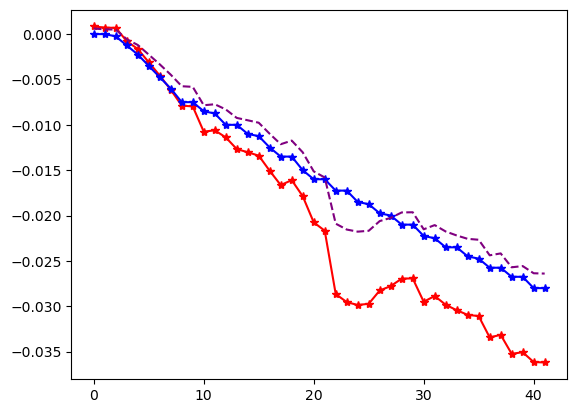

In [364]:
points_th_fit = straight_fit(np.linspace(0, len(md_information['coast4']['tidp_bump_theoretical'])-1, len(md_information['coast4']['tidp_bump_theoretical'])), coeffs_th_bump)
points_md_fit = straight_fit(np.linspace(0, len(md_information['coast4']['tidp_bump_md'])-1, len(md_information['coast4']['tidp_bump_md'])), coeffs_md_bump)
plt.figure()
plt.plot(md_information['coast4']['tidp_bump_md'], '*-', color='red')
plt.plot(md_information['coast4']['tidp_bump_theoretical'], '*-', color='blue')
#plt.plot(points_md_fit, '--', color='green', label='bph.11408 fit')
#plt.plot(points_th_fit, '--', color='orange', label='tidp.11434 fit')
#plt.plot(points_md_fit*coeffs_th_bump[0]/coeffs_md_bump[0], '--', color='purple', label='bph.11408 fit scaled')
plt.plot(md_information['coast4']['tidp_bump_md']*coeffs_th_bump[0]/coeffs_md_bump[0], '--', color='purple', label='bph.11408 fit scaled')

fitting and using conversion factor as comparison of slopes seems a valid way of comparing, data ok if considering variation ?